# **Vehicle Detection and Tracking** 
***
In this project, you will use the computer vision and machine learning tools to identify and track the vehicles on the road. 
I develeoped a pipeline that gets a videao sream recorded from a vehicles front camera and creates a output stream with the located cars positions with rectangles. The result of the pipeline can be seen [**here**](https://youtu.be/UZBfoNYezt4)

 

### 1. Model Construction
We can slipt the model construction section into three parts Data Exploration, Feature Extraction & Selection and Model Training. You can find the whole code in train.py file (it also uses some method in lesson_functions.py) 

#### 1.1 Data Exploration

The labeled data for vehicle and non-vehicle examples to train the classifier to identify vehicles is combination of [**GTI vehicle image database**](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [**KITTI vision benchmark suite**](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself. You can see the codes to read the vehicle and non-vehicle data from the files. Note: data is not included to the repository it can be dowload from the links given above.

Number of vehicle data :  8792
Number of non-vehicle data :  8968


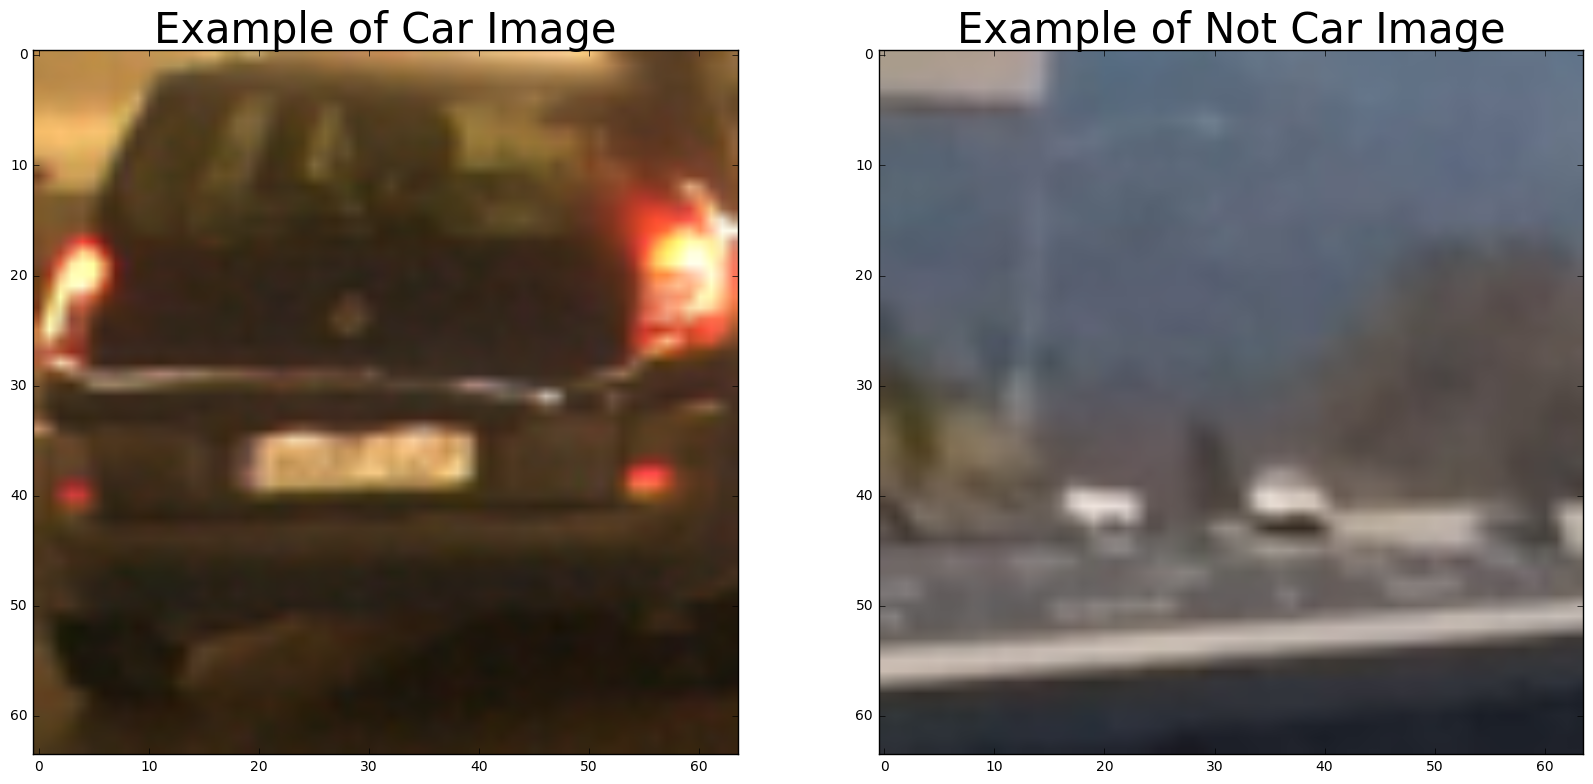

In [3]:
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#get directory of the car images
car_images_path = os.getcwd()+'/vehicles'

#load the car images data
cars = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(car_images_path)
    for f in files if f.endswith('.png')]

#get directory of the non-car images
non_car_images_path = os.getcwd()+'/non-vehicles'

#load the non-car images data
notcars = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(non_car_images_path)
    for f in files if f.endswith('.png')]

print('Number of vehicle data : ', len(cars))
print('Number of non-vehicle data : ', len(notcars))

# Visualize data example
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(mpimg.imread(cars[0]))
ax1.set_title('Example of Car Image', fontsize=30)
ax2.imshow(mpimg.imread(notcars[0]))
ax2.set_title('Example of Not Car Image', fontsize=30)
plt.show()


#### 1.2 Feature Extraction and Selection 

First of all before extracting the image feaures the images is converted to YCrCb from the RGB color space becuase it is seen that it gives better result. To train a good classifier for the given task first we need to extract feature from the data. In this project histograms of colors, spatial binning of color and Histogram of Oriented Gradient (HOG) feaute extraction methods are used to extract the feature. 
In the code bellow you can see the method that is used for feature extraction 

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(images, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    :param images: image data
    :param color_space: color space to convert the image
    :param spatial_size: size to reduce resolution
    :param hist_bins: bin size for color histograms
    :param orient: number of orientation bins
    :param pix_per_cell: pixel size of a cell
    :param cell_per_block: number of cells in each block
    :param hog_channel: channel to be used for hog  
    :param spatial_feat: flag to check if spatial features will be used
    :param hist_feat: flag to check if color histogram features will be used
    :param hog_feat: flag to check if hog features will be used
    :return: combined feature vector
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in images:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


###### 1.2.1 Spatial Binning of Color
Firstly, we can use raw pixel values in our feature vector to search vehicles. However to include raw pixel values from all 3 channel will put a huge burden on the system. Therefore we decrease the resolution and we see that it is still a good information source Therefore cv2.resize() function is used to decrease the resolution to 16x16 then we applied the ravel() function on resized image to get one dimensional feature vector. We used the bin_spatial method from the lesson fuction with spatial_size equals 16. Finally we append the new features to the feature vector.
          
    
    if spatial_feat == True:
       spatial_features = bin_spatial(feature_image, size=spatial_size)
       file_features.append(spatial_features)

    #Define a function to compute binned color features
    def bin_spatial(img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel()
        #Return the feature vector
        return features

##### 1.2.2 Histograms of Color 
Color can be a good indicator to identify vehicles and non vehicles images. For that purpose first we calculate histograms of pixel intensity of all 3 channels with histogram bin size 16 and add that histograms to our feature vector. Finally we append the new features to the feature vector.

    if hist_feat == True:
        # Apply color_hist() 
        hist_features = color_hist(feature_image)
        file_features.append(hist_features)

    #Define a function to compute color histogram features
    #NEED TO CHANGE bins_range if reading .png files with mpimg!
    def color_hist(img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
        #Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        #Return the individual histograms, bin_centers and feature vector
        return hist_features

###### 1.2.3 Histogram of Oriented Gradients (HOG) 
Histogram of Oriented Gradients is commonly used feature descriptor in image processing for object detection. To extract the HOG features 
**hog** method is used form skimage package to extract hog features. First I tried the same parametes as in the lesson they were ok but then the parameters were tuned according to test results. How the parameters have been choosen will be explaine din the Model Training Section. 

        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)

    #Define a function to return HOG features and visualization
    def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                         vis=False, feature_vec=True):
        #Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient,
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block),
                                      transform_sqrt=True,
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        #Otherwise call with one output
        else:
            features = hog(img, orientations=orient,
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block),
                           transform_sqrt=True,
                           visualise=vis, feature_vector=feature_vec)
            return features
            
 ##### 1.3 Feature Normalization
 After extracting the feautures we need to normalize the feature vector as it caontains different types of features with different scales. Thus we use StandardScaler() from sklearn package to scale the final feature vector. 
 
        #combine and convert the type of the feture vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        
##### 1.4 Model Training

Support Vector Machine (SVM) to classification of the car and not car images. From sklearn package we use LinearSVC class to model the Linear Support Vector Machine as our classifier. The method for traing and testing shown in the cell bellow. First we create the car and not cars features vector then normalized the combined feature vectors then we split the data for traiing and testing. We used the 80% of the data for traing and rest for to test. 

Firstly, we used the same parameters as we used in the lesson for the feature extraction and traing. So we created a feature vector with size 4932 and it took 45.18 to traing the linear svc model and it resulted with 0.9704 testing accuracy. After that we tried to change the parameters one by one the first one we begun with was color space. Firsly  I chnage the hog channel to all so it uses the all three channel then I tried  all color spaces with the same parameters and the YCrCb color space with all channles the same parametes above gave the best result. (and YUV was the worst one the model that trained with YUV color space never found a car.) However, with using all chanlles the feature vector traing and searching/detection time (this is the most important one because we want to search and detect the cars in real time) incereased. After that we decreased the spatial size to (16, 16) and histogram bins to 16 and orient to 8 in order to decrease the feature vector and search time. After all experiments with the parametes I found the best parmaters are given bellow. You can see the codes and the results of the best found parameters on two cell bellow. 

Parameters: {'spatial_size': (16, 16), 'hog_channel': 'ALL', 'cell_per_block': 2, 'pix_per_cell': 8, 'hog_feat': True, 'hist_feat': True, 'orient': 8, 'spatial_feat': True, 'color_space': 'YCrCb', 'hist_bins': 16}



In [5]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split




# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255
def create_search_windows(search_windows,image):
    '''
    Method to create search windows list
    :param search_windows: list to append the search windows
    :param image: image to be search on
    :return: None
    '''
    search_windows += slide_window(image.shape, x_start_stop=[None,None],
                                        y_start_stop=[400, 500],
                                        xy_window=(80, 80), xy_overlap=(0.75, 0.75))
    search_windows += slide_window(image.shape, x_start_stop=[None, None],
                                        y_start_stop=[400, 500],
                                        xy_window=(100, 100), xy_overlap=(0.75, 0.75))
    search_windows += slide_window(image.shape, x_start_stop=[None, None],
                                        y_start_stop=[420, 660],
                                        xy_window=(120, 120), xy_overlap=(0.5, 0.5))
    search_windows += slide_window(image.shape, x_start_stop=[None, None],
                                        y_start_stop=[500, 690],
                                        xy_window=(160, 160), xy_overlap=(0.5, 0.5))


def train_test_model(parameters,do_training=False,model_path = 'models/linear_svc.p', image = None):
    '''
     Method to train and test the model
    :param parameters: a dict that contains traing parameters (hog features, bin size, spatial szie etc.)
    :param do_training: a flag if we want to do training
    :param model_path: path to save model in
    :param image:  image file to test the model
    :return: image contains the boxes on the car position
    '''

    #cehck the model files exist if not do trainig or if the do_training is True restart train'ng the ex'st'ng model
    if not os.path.isfile(model_path) or do_training:
        print('Train the model.')
        t = time.time()
        # Extract the car features and create the feature vector
        car_features = extract_features(cars, color_space=color_space,
                                        spatial_size=spatial_size, hist_bins=hist_bins,
                                        orient=orient, pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                                        hist_feat=hist_feat, hog_feat=hog_feat)

        # Extract the notcar features and create the feature vector
        notcar_features = extract_features(notcars, color_space=color_space,
                                           spatial_size=spatial_size, hist_bins=hist_bins,
                                           orient=orient, pix_per_cell=pix_per_cell,
                                           cell_per_block=cell_per_block,
                                           hog_channel=hog_channel, spatial_feat=spatial_feat,
                                           hist_feat=hist_feat, hog_feat=hog_feat)

        #combine and convert the type of the feture vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        print('Parameters:',parameters)
        print('Feature vector length:', len(X_train[0]))
        # Use a linear SVC
        svc = LinearSVC()
        # Check the training time for the SVC

        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2 - t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        with open(model_path, 'wb') as model_file:
            pickle.dump({'svc': svc,'X_scaler': X_scaler,'parameters': parameters},model_file,pickle.HIGHEST_PROTOCOL)
        print('Model has saved to ' ,model_path)
    else:
        with open(model_path, 'rb') as model_file:
            model = pickle.load(model_file)
            svc = model['svc']
            X_scaler = model['X_scaler']
            parameters = model['parameters']
    if image is not None:
        draw_image = np.copy(image)
        windows = []
        create_search_windows(windows, image)
        print('windows size : ', len(windows))

        image = image.astype(np.float32) / 255
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=parameters['color_space'],
                                        spatial_size=parameters['spatial_size'], hist_bins=parameters['hist_bins'],
                                        orient=parameters['orient'], pix_per_cell=parameters['pix_per_cell'],
                                        cell_per_block=parameters['cell_per_block'],
                                        hog_channel=parameters['hog_channel'], spatial_feat=parameters['spatial_feat'],
                                        hist_feat=parameters['hist_feat'], hog_feat=parameters['hog_feat'])

        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img


/home/burak/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:

color_space = 'RGB'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 0  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
y_start_stop = [400, 690]  # Min and max in y to search in slide_window()



rgb_parameters = { 'color_space' : color_space,
               'orient': orient ,
               'pix_per_cell': pix_per_cell,
               'cell_per_block':cell_per_block,
               'hog_channel':hog_channel,
               'hist_bins':hist_bins,
               'spatial_feat':spatial_feat,
               'hist_feat':hist_feat,
               'hog_feat':hog_feat,
               'spatial_size':spatial_size }



RGB_model_path = 'models/RGB_linear_svc.p'
#taing the model with above parameters and save it to the disk 
print('--------------------------------------------------------------')
print("Start traing for RGB. ")
train_test_model(rgb_parameters,do_training=True, model_path=RGB_model_path)
print('Traing completed for RGB. ')
print('--------------------------------------------------------------')
print()


#change the parametes and do traing again
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
y_start_stop = [400, 690]  # Min and max in y to search in slide_window()



ycrcb_parameters = { 'color_space' : color_space,
               'orient': orient ,
               'pix_per_cell': pix_per_cell,
               'cell_per_block':cell_per_block,
               'hog_channel':hog_channel,
               'hist_bins':hist_bins,
               'spatial_feat':spatial_feat,
               'hist_feat':hist_feat,
               'hog_feat':hog_feat,
               'spatial_size':spatial_size }




YCrCb_model_path = 'models/YCrCb_linear_svc.p'
#taing the model with above parameters and save it to the disk 
print('--------------------------------------------------------------')
print("Start traing for YCrCb. ")
train_test_model(ycrcb_parameters,do_training=True, model_path=YCrCb_model_path)
print('Traing completed for YCrCb. ')
print('--------------------------------------------------------------')

--------------------------------------------------------------
Start traing for RGB. 
Train the model.
Parameters: {'spatial_feat': True, 'hog_feat': True, 'spatial_size': (32, 32), 'color_space': 'RGB', 'cell_per_block': 2, 'hist_feat': True, 'hist_bins': 32, 'pix_per_cell': 8, 'orient': 9, 'hog_channel': 0}
Feature vector length: 4932
47.9 Seconds to train SVC...
Test Accuracy of SVC =  0.9718
Model has saved to  models/RGB_linear_svc.p
Traing completed for RGB. 
--------------------------------------------------------------

--------------------------------------------------------------
Start traing for YCrCb. 
Train the model.
Parameters: {'spatial_feat': True, 'hog_feat': True, 'spatial_size': (16, 16), 'color_space': 'YCrCb', 'cell_per_block': 2, 'hist_feat': True, 'hist_bins': 16, 'pix_per_cell': 8, 'orient': 8, 'hog_channel': 'ALL'}
Feature vector length: 5520
79.32 Seconds to train SVC...
Test Accuracy of SVC =  0.9876
Model has saved to  models/YCrCb_linear_svc.p
Traing compl

windows size :  245
0.36 procesing time for RGB
windows size :  245
0.89 procesing time for YCrCb.


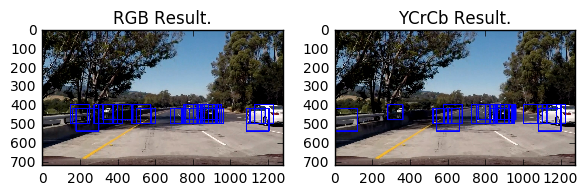

windows size :  245
0.43 procesing time for RGB
windows size :  245
0.96 procesing time for YCrCb.


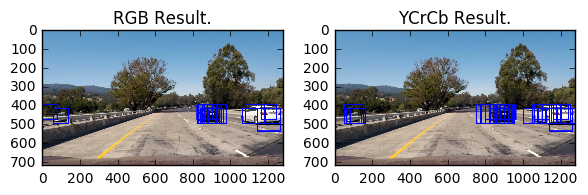

windows size :  245
0.39 procesing time for RGB
windows size :  245
0.94 procesing time for YCrCb.


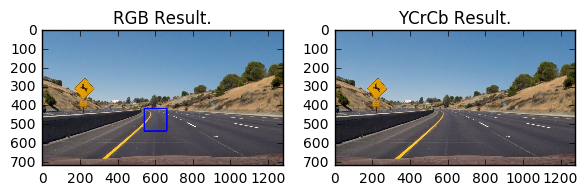

windows size :  245
0.39 procesing time for RGB
windows size :  245
1.01 procesing time for YCrCb.


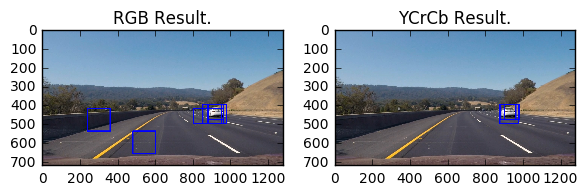

windows size :  245
0.39 procesing time for RGB
windows size :  245
0.94 procesing time for YCrCb.


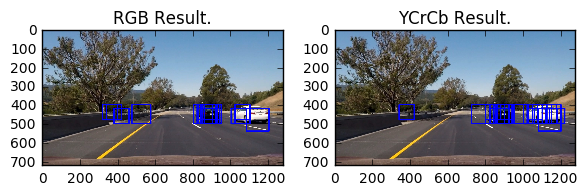

windows size :  245
0.43 procesing time for RGB
windows size :  245
0.9 procesing time for YCrCb.


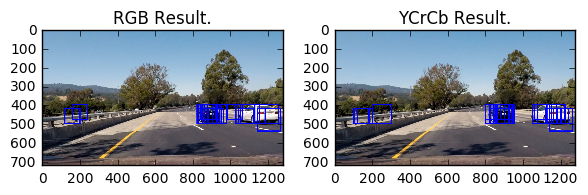

In [9]:



import glob
images = glob.glob('test_images/*.jpg')
for image_path in images:
    image = mpimg.imread(image_path)
    
    
    t = time.time()
    RGB_result = train_test_model(rgb_parameters,do_training=False, model_path=RGB_model_path,image=image)
    t2 = time.time()
    print(round(t2 - t, 2), 'procesing time for RGB')
    
    t = time.time()
    YCrCb_result = train_test_model(ycrcb_parameters,do_training=False, model_path=YCrCb_model_path,image=image)
    t2 = time.time()
    print(round(t2 - t, 2), 'procesing time for YCrCb.')
    

    
    
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(RGB_result)
    plt.title('RGB Result.')
    plt.subplot(122)
    plt.imshow(YCrCb_result)
    plt.title('YCrCb Result.')
    fig.tight_layout()
    plt.show()

##### Sliding Window Search
Vehicle can be certain location and size on the recorded frame rom the fron camera of the car. We need a method to search the cars on those position for that purpose we created windows where the cars can be in so that cars can be found half bottom on the frame (the upper buttom is mostly sky or something else) and car sizes (on the image in pixel) increase on the buttom. Hence we created 4 different sizes of square (80,100,120 and 160) windows according to y coordinates. Also we set the xy overlap of the 80 and 100 size widnows to 0.75 because we want to move overlap to don't miss the car (since it is higly possible to miss the car with the low overlaping and small windows). for the 120 and 160 size windows we set the xy overlap to 0.5 in order to not increase the windows size (it will eventually increse the procesing time and decrease the fps). In the end you can see the all windows on the example imga ein the cell bellow there are total 245 windows to search. 

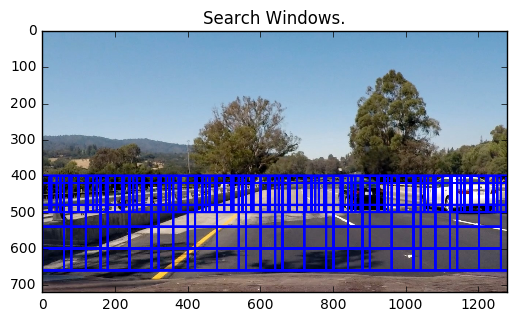

In [15]:
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255
def create_search_windows(search_windows,image):
    '''
    Method to create search windows list
    :param search_windows: list to append the search windows
    :param image: image to be search on
    :return: None
    '''
    search_windows += slide_window(image.shape, x_start_stop=[None,None],
                                        y_start_stop=[400, 500],
                                        xy_window=(80, 80), xy_overlap=(0.75, 0.75))
    search_windows += slide_window(image.shape, x_start_stop=[None, None],
                                        y_start_stop=[400, 500],
                                        xy_window=(100, 100), xy_overlap=(0.75, 0.75))
    search_windows += slide_window(image.shape, x_start_stop=[None, None],
                                        y_start_stop=[420, 660],
                                        xy_window=(120, 120), xy_overlap=(0.5, 0.5))
    search_windows += slide_window(image.shape, x_start_stop=[None, None],
                                        y_start_stop=[500, 690],
                                        xy_window=(160, 160), xy_overlap=(0.5, 0.5))
    
search_windows = []
create_search_windows(search_windows,image)
search_window_img = draw_boxes(image, search_windows, color=(0, 0, 255), thick=6)
plt.imshow(search_window_img)
plt.title('Search Windows.')
plt.show()

##### Vehicle Tracking

After sliding window search we have multiple detections and false positives to be worked on. Moreover we need to track the vehicles on the video stream. In order to track the vehicles on the video stream we implemented Box and VehicleDetector classes. Box class is a data stucture to represent the rectangles (located vehicles) on the image. It has several methods to calculate certain features (size, distance, age , heat ,center location and speed ) also there is an checker to compare boxes (vehicles) to decide if the two boxes is almost identical. 

    def is_equal(self, other):
        """
            Checks if the given box has similar attributes
            :param other box to compare
        """
        return self.close(other) & (abs(self.width - other.width) < 100) & (abs(self.height - other.height) < 50)

On a video stream we have series of images to process and in order to track the vehicles we need to store the old positons and compare those with the new found images. Also the vehicles postions and the sizes don't change too much on the next frame. The above Box method uses that information to identify if the vechile has already found on the previous frames. 

VehicleDetector class maninly stores the parameters and the old vechicle postions that previously found. The main procedure that used in this project to get rid of false postives after sliding window search and track the vehicles is given bellow. 
    
    VehicleDetector.old_postions = []
    VehicleDetector.car_list = []
    def process_image(image):
   
    # uses the pre trained model and uses sliding windows search to locate the vehicles (output has false positives and multiple detections
    hot_windows = search_windows(image,model)
    
    # create heat map to unify multiple overlap detections and get rid of some false postives by applying a threshold
    heatmap = create_heat_map(hot_windows) 

    # store previously found cars 
    VehicleDetector.old_positions = vehicleDetertor.car_list 
    
    # checks the heatmap and the previosuly found cars to locate the new cars on the new frame  
    VehicleDetertor.car_list = locate_cars(heatmap)

    
    # draw the found vehicles which heat is greater than some threshold 
    draw_img = draw_boxes(image, vehicleDetertor.car_list)
    return draw_img
    
    
The most important method I think is 'locate_cars' method. Firstly it gets the heatmap of the new frame and it uses [**label method**](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html) to identify box corners and add them to the box list. After that it goes through the previoulsy found box list and compare them to new box list one by one. If a box in the old box list is almost same as the one of the new found one then update the new box features (increase heat, decrease age and calculate the size according to old box). If the box in the old list has no match with the new boxes but it has a high heat and low age value then we put the old box to box_list ( the model that founds the cars failes to detec the cars on some frames we use the heat values and previous boxes to track the vehicles and not loose them). Also the old cars has 

    # method checks heat map and old posionts to update the found car list (VehicleDetector.car_list) 
    def locate_cars(heatmap): 
        # uses Label class to identify rectangle corners and create boxes by using corners coordinates 
        box_list = label(heatmap)
        
        for box in boxes: 
            for old_box in VehicleDetector.old_positions:
                if is_equal(box,odl_box) then increase box heat and set the box age to zero.
                else if old_box heat is greater than the threshold add the old_box to the box_list
         return box_list 
         

The draw_boxes method draws the boxes has heat greater 14 to get rid of the false positives. Also it check the age value of the boxes in order not to show vechiles that already is out of the frame and previosly has high heat values. 

In order to increase the procesing speed we used Pool class to search to slidng window search. We created 4 instances and seperate the search windows into 4 sub regions and search those regions in paralel. 


## Discussion

The main problem to track the cars on a video stream is the false postives (and also the cars on the opposite lanes). In order to get rid of those we needed to keep track and increse the heat if we detect the same vehicle on squential frames. Chencking the previously gound vehicles also helps to not loose the vehcile even if the model couldn't detect the vehicle for some frames. 

In the feature work the car postion can be used to calculate the car size more accurelly and to have a smooth fame over the stream while the cars is slowly moveing away (or getting closer). We can also use the speed info to have better guess where the vehcile can be on the next frame. 